- Load Packages

In [1]:
import atlite
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from atlite.gis import shape_availability, ExclusionContainer
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

import pygadm
from pathlib import Path
import plotly.express as px
import random
import plotly.graph_objects as go
import random
from plotly.subplots import make_subplots

In [2]:
import sys
import os

# Add the 'scripts' folder to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Now you can import your module
import timeseries_vis as ts_vis

# Use the functions or classes from timeseries_vis

# Load Boundaries

> Replacing with pyGadm as naturalearth_lowres has been removed from stock database of geopandas

In [3]:
""" 
countries = ['Serbia', 'Bosnia and Herz.', 'Montenegro']
plt.rcParams['figure.figsize'] = [7, 7]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

shapes = world[world.name.isin(countries)].set_index('name')

shapes.plot();
"""

" \ncountries = ['Serbia', 'Bosnia and Herz.', 'Montenegro']\nplt.rcParams['figure.figsize'] = [7, 7]\nworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))\n\nshapes = world[world.name.isin(countries)].set_index('name')\n\nshapes.plot();\n"

In [4]:
## List of countries
countries:list = ['Serbia', 'Bosnia and herzegovina', 'Montenegro'] # Names used to match GADM database

## Initialize an empty list to hold GeoDataFrames
_gdfs_:gpd.GeoDataFrame = []

## Loop through the countries and fetch administrative items
for country in countries:
    gdf = pygadm.AdmItems(name=country, content_level=0) # Using Level 0 for now
    _gdfs_.append(gdf)  # Add each GeoDataFrame to the list

## Combine all GeoDataFrames into one
countries_gdf:gpd.GeoDataFrame = pd.concat(_gdfs_, ignore_index=True)
countries_gdf.crs=4326

# Assuming 'countries_gdf' is your GeoDataFrame
countries_gdf = countries_gdf.rename(columns={'NAME_0': 'Country','GID_0':'ISO'})

countries_gdf=countries_gdf.set_index('ISO')


In [5]:
## Visualize the geodataframe
# countries_gdf.explore('VARNAME_1')  # interactive map

# Prepare Cutout

* Create MBR (Minimum Bounding Rectangle) Coordinates from the geodatafram

In [6]:
buffer:float=1 # m , if CRS= 4326
bounds:tuple = countries_gdf.unary_union.buffer(buffer).bounds  #revised the MBR (minimum bounding rectangle) codes to match new goepandas versiopon. 

* Setup Cutout Configs

In [7]:
cutout_path:Path=Path('../data/downloaded/ERA5/DRB_2020.nc')
cutout_snapshot:slice=slice('2020-01-01', '2020-12-31')
cutout_path.parent.mkdir(parents=True, exist_ok=True) # Ensure the parent directory exists

cutout:atlite.Cutout = atlite.Cutout(cutout_path, 
                                     module='era5', 
                                     bounds=bounds, 
                                     time=cutout_snapshot)
print(f"Cutout config set to:\n {80*'_'}\n {cutout}")

## Visualize Cutout's Grid

# fig, ax = plt.subplots(figsize=(20,20))
# countries_gdf.plot(ax=ax)
# cutout.grid.plot(ax=ax, edgecolor='grey', color='None')

# cutout.grid.explore()  # interactive map

cutout.prepare()

INFO:atlite.data:Cutout already prepared.


Cutout config set to:
 ________________________________________________________________________________
 <Cutout "DRB_2020">
 x = 14.75 ⟷ 23.75, dx = 0.25
 y = 41.00 ⟷ 47.00, dy = 0.25
 time = 2020-01-01 ⟷ 2020-12-31, dt = h
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']


<Cutout "DRB_2020">
 x = 14.75 ⟷ 23.75, dx = 0.25
 y = 41.00 ⟷ 47.00, dy = 0.25
 time = 2020-01-01 ⟷ 2020-12-31, dt = h
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

# Load Exclusion/Inclusion Geospatial Layers

- Load Rasters


In [8]:
CORINE :Path= Path('../data/downloaded/CORINE_EU/corine.tif')
CORINE.parent.mkdir(parents=True, exist_ok=True) # Ensure the parent directory exists

- Setup Exclusion Container from Atlite's GIS module

In [9]:
excluder = ExclusionContainer()
excluder.add_raster(CORINE, codes=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,34,35,36,37,38,39,40,41,42,43,44,45))
print(f"Atlite's Exclusion Container Loaded: \n{50*'_'}\n{excluder}")

Atlite's Exclusion Container Loaded: 
__________________________________________________
Exclusion Container
 registered rasters: 1 
 registered geometry collections: 0
 CRS: 3035 - Resolution: 100


In [10]:
# import rioxarray
# import matplotlib.pyplot as plt

# # Open the TIFF file as an xarray DataArray
# raster = rioxarray.open_rasterio('corine.tif')

# # Display metadata
# print(raster)

# # Plot the raster data
# raster.plot(cmap="viridis", figsize=(10, 6))
# plt.title("TIFF Raster")
# plt.show()


* Prepare the Country Geometries

In [11]:
# # serbia = shapes.loc[['Serbia']].geometry.to_crs(excluder.crs)
# serbia = countries_gdf.loc[countries_gdf['Country'] == 'Serbia'].geometry.to_crs(excluder.crs)
# # bosnia = shapes.loc[['Bosnia and Herz.']].geometry.to_crs(excluder.crs)
# bosnia = countries_gdf.loc[countries_gdf['Country'] == 'Bosnia and Herzegovina'].geometry.to_crs(excluder.crs)  # The country name is loaded as 'Bosnia and Herzegovina'
# # montenegro = shapes.loc[['Montenegro']].geometry.to_crs(excluder.crs)
# montenegro = countries_gdf.loc[countries_gdf['Country'] == 'Montenegro'].geometry.to_crs(excluder.crs)

> Test:  Calculate Eligibility Share with Atlite

In [12]:
countries_geoms=countries_gdf.geometry.to_crs(excluder.crs)
masked, transform = shape_availability(countries_geoms,excluder)
    
# Calculate the eligible share
eligible_share = (
    masked.sum() * (excluder.res ** 2) / countries_geoms.area
)


print(f"Country Eligibility Share Calculated: \n {50*'_'}")
for iso, share in eligible_share.items():
    print(f"{countries_gdf.loc[iso, 'Country']}: {round(share * 3)}%")
    
    
# Impute the data to countries gdf
countries_gdf['eligible_land'] = countries_gdf.index.map(eligible_share)

# Save local file for later usage
countries_gdf_save_to=Path('../data/downloaded/countries.geojson')
countries_gdf_save_to.parent.mkdir(parents=True, exist_ok=True) # Ensure the parent directory exists

countries_gdf.to_file(countries_gdf_save_to, driver="GeoJSON")

INFO:pyogrio._io:Created 3 records


Country Eligibility Share Calculated: 
 __________________________________________________
Serbia: 1%
Bosnia and Herzegovina: 1%
Montenegro: 5%


* Visuals

In [13]:
# fig, ax = plt.subplots()
# ax = show(masked, transform=transform, cmap='Greens', ax=ax)
# bosnia.plot(ax=ax, edgecolor='k', color='none',figsize=(15, 25))
# ax.set_title(f"Bosnia's Eligible area (green) {eligible_share * 100:2.4f}%");
# plt.savefig('vis/RS_2020.png', dpi=300)

In [14]:
# fig, ax = plt.subplots()
# ax = show(masked, transform=transform, cmap='Greens', ax=ax)
# bosnia.plot(ax=ax, edgecolor='k', color='None')
# cutout.grid.to_crs(excluder.crs).plot(edgecolor='grey', color='None', ax=ax, ls=':')
# ax.set_title(f'Eligible area (green) {eligible_share * 100:2.2f}%');

# Calculate Availability matrix

In [15]:
A = cutout.availabilitymatrix(countries_gdf, excluder)
print(f"Land availability matrix calculated.")

Land availability matrix calculated.


* Visuals

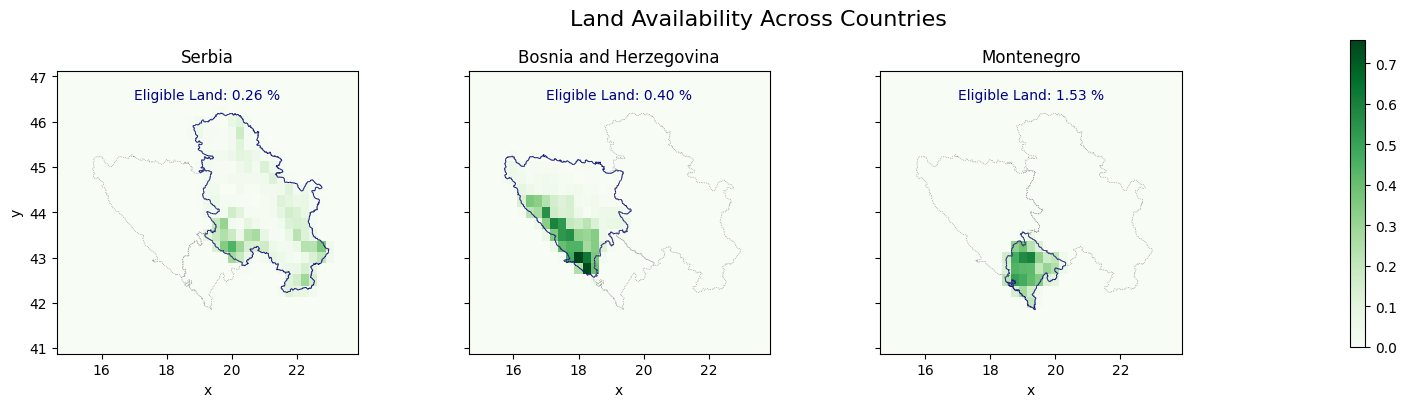

In [16]:
fg = A.plot(row='ISO', col_wrap=4, cmap='Greens', aspect=1, size=4)

# Add a super title
fg.fig.suptitle('Land Availability Across Countries', fontsize=16, y=.99)

# Loop through each country and plot its geometry
for i, c in enumerate(countries_gdf.index):
    # Access the country geometry and eligible land value
    ax = fg.axes.flatten()[i]
    country_geom = countries_gdf.loc[c, 'geometry']
    eligible_land = countries_gdf.loc[c, 'eligible_land']  # Get the eligible land value
    
    # Plot the country geometry
    countries_gdf.loc[[c]].plot(ax=ax, edgecolor='navy', color='None',linewidth=0.7,ls="-")
    countries_gdf.plot(ax=ax, edgecolor='grey', color='None',linewidth=0.5,ls=":")
    
    # Add the eligible land value as text in the plot (adjust x and y for positioning)
    ax.text(0.5, 0.9, f'Eligible Land: {eligible_land:.2f} %', 
            transform=ax.transAxes, fontsize=10, ha='center', color='navy')
    
    # Set the title for each subplot (use the 'Country' column to get the country name)
    country_name = countries_gdf.loc[c, 'Country']
    ax.set_title(country_name, fontsize=12)

plt.tight_layout()
# Save the figure with the added eligible land data
plt.savefig('../vis/Land_availability_DRB_riparians_2020.png', dpi=600)

# Calculate Potential Capacity using Land-use Intensity

In [17]:
cap_per_sqkm = 1.7
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))

capacity_matrix = A.stack(spatial=['y', 'x']) * area * cap_per_sqkm

## Calculate PV power

In [18]:
pv = cutout.pv(matrix=capacity_matrix, panel=atlite.solarpanels.CdTe,
               orientation='latitude_optimal', index=countries_gdf.index)    

INFO:atlite.convert:Convert and aggregate 'pv'.


In [19]:
pv_df=pv.to_pandas().div(1e3) # GW
pv_df.to_csv('../results/solar_cf_2020.csv')

* TS visuals (interactive)

In [20]:
ts_vis.plot_timeseries(df=pv_df, 
                    countries_gdf=countries_gdf, 
                    save_path=Path('../vis/timeseries/Solar_timeseries_plot.html'),
                    plot_title="Solar")

## Calculate WIND power

INFO:atlite.convert:Convert and aggregate 'wind'.
INFO:atlite.convert:Convert and aggregate 'wind'.


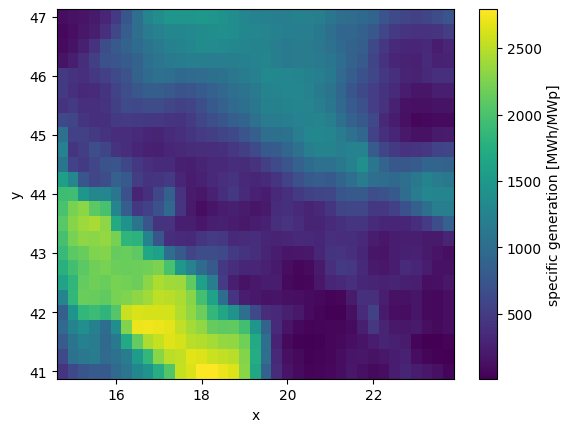

In [21]:
wind = cutout.wind(matrix=capacity_matrix, turbine='Siemens_SWT_2300kW',
               index=countries_gdf.index)
cutout.wind(turbine='Siemens_SWT_2300kW').plot()

* Create dataframe and save local copies as csvs

In [22]:
wind_df=wind.to_pandas().div(1e3) # GW
wind_df.to_csv('../results/wind_cf_2020.csv')

* Visuals (interactive ts)

In [23]:
ts_vis.plot_timeseries(df=wind_df, 
                    countries_gdf=countries_gdf, 
                    save_path=Path('../vis/timeseries/Wind_timeseries_plot.html'),
                    plot_title="Wind")